In [1]:
import pandas as pd

In [2]:
data_model_output = pd.read_csv('../data/processed/data_model_output.csv')

C:\Users\USVV724227\AppData\Local\Temp\ipykernel_35776\1409545975.py:1: DtypeWarning: Columns (1,13,14,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,48,54,55,59,65,69,74,77,78,80,82,83,86,93,95,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,132,142,147,150,151,152,155,156,157,167,169,177,179,196,197,198,201,210,211,216,223,237,239,240,241,242,243,244,246,248,249,273,283,284,285,288,291,295,296,297,299,300,335,337,338,340,411,414) have mixed types. Specify dtype option on import or set low_memory=False.
  data_model_output = pd.read_csv('../data/processed/data_model_output.csv')


In [3]:
data_model_output.head()

,unique_id,respondentid,is_completed,is_valid_record,date_completed,time_completed,is_pilot,is_self_administered,record_type_synthetic,access_mode,...,validation_error_trip,validation_num_errors_person,validation_num_errors_trip,validation_severity_person,validation_severity_trip,weight,weight_departing_and_arriving,weight_departing_only,weight_departing_only_with_time_of_day,weight_non_sas_departing_only
0,1,5473,True,True,2024-10-04,08:41:12,False,False,0,NaN,...,[],0,0,NaN,NaN,1.0,1.0,1.0,1.0,1.0
1,2,5476,True,True,2024-10-04,08:40:04,False,False,0,1.0,...,[],0,0,NaN,NaN,1.0,1.0,1.0,1.0,1.0
2,3,5489,True,True,2024-10-04,08:51:36,False,False,0,NaN,...,[],0,0,NaN,NaN,1.0,1.0,1.0,1.0,1.0
3,4,5558,True,True,2024-10-04,10:32:58,False,False,0,1.0,...,[],0,0,NaN,NaN,1.0,1.0,1.0,1.0,1.0
4,5,5593,True,True,2024-10-04,11:09:46,False,False,0,1.0,...,[],0,0,NaN,NaN,1.0,1.0,1.0,1.0,1.0


In [4]:
import pandas as pd

# Filter data for relevant passenger segments
filtered_data = data_model_output[
    data_model_output['passenger_segment_label'].isin(['RESIDENT_ARRIVING', 'RESIDENT_DEPARTING'])
]

# Create new columns for municipal_zone and pmsa based on passenger segment type
filtered_data['municipal_zone'] = filtered_data.apply(
    lambda row: row['destination_municipal_zone'] if row['passenger_segment_label'] == 'RESIDENT_ARRIVING' else row['origin_municipal_zone'],
    axis=1
)

filtered_data['pmsa'] = filtered_data.apply(
    lambda row: row['destination_pmsa'] if row['passenger_segment_label'] == 'RESIDENT_ARRIVING' else row['origin_pmsa'],
    axis=1
)

# Adjust party size and create weighted party size
filtered_data['party_size_weighted'] = filtered_data['party_size_flight'] * filtered_data['weight']

# Define a function to generate the required summaries
def generate_summaries(group_col):
    summary_weight = filtered_data.groupby(group_col).agg(
        weighted_num_travelers = ('party_size_weighted', 'sum'),
        weighted_num_parties = ('weight', 'sum')
    ).reset_index()
    
    summary_respondents_all = filtered_data.groupby(group_col).agg(
        num_travelers_all = ('party_size_flight', 'sum'),
        num_travel_parties_all = ('unique_id', 'count')
    ).reset_index()

    summary_respondents_non_synthetic = filtered_data[filtered_data['record_type_synthetic'] == 0].groupby(group_col).agg(
        num_travelers_non_synthetic = ('party_size_flight', 'sum'),
        num_travel_parties_non_synthetic = ('unique_id', 'count')
    ).reset_index()
    
    return summary_weight, summary_respondents_all, summary_respondents_non_synthetic

# Generate summaries for municipal_zone
summary_municipal_zone_weight, summary_municipal_zone_respondents_all, summary_municipal_zone_respondents_non_synthetic = generate_summaries('municipal_zone')

# Generate summaries for pmsa
summary_pmsa_weight, summary_pmsa_respondents_all, summary_pmsa_respondents_non_synthetic = generate_summaries('pmsa')

C:\Users\USVV724227\AppData\Local\Temp\ipykernel_35776\892705268.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['municipal_zone'] = filtered_data.apply(
C:\Users\USVV724227\AppData\Local\Temp\ipykernel_35776\892705268.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['pmsa'] = filtered_data.apply(
C:\Users\USVV724227\AppData\Local\Temp\ipykernel_35776\892705268.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [5]:
# Merge summaries for municipal_zone
# Merge summaries for municipal_zone
summary_municipal_zone = (
    summary_municipal_zone_weight
    .merge(summary_municipal_zone_respondents_all, on='municipal_zone', how='outer')
    .merge(summary_municipal_zone_respondents_non_synthetic, on='municipal_zone', how='outer')
)

#Change column order
summary_municipal_zone = summary_municipal_zone[['municipal_zone', 'num_travel_parties_non_synthetic','num_travel_parties_all', 'weighted_num_parties', 'num_travelers_non_synthetic', 'num_travelers_all', 'weighted_num_travelers']]

#Move external to end
# Separate rows with 'EXTERNAL' and others
external_row = summary_municipal_zone[summary_municipal_zone["municipal_zone"] == "EXTERNAL"]
other_rows = summary_municipal_zone[summary_municipal_zone["municipal_zone"] != "EXTERNAL"]

# Concatenate with 'EXTERNAL' at the end
summary_municipal_zone = pd.concat([other_rows, external_row], ignore_index=True)


# Merge summaries for pmsa
summary_pmsa = (
    summary_pmsa_weight
    .merge(summary_pmsa_respondents_all, on='pmsa', how='outer')
    .merge(summary_pmsa_respondents_non_synthetic, on='pmsa', how='outer')
)
#Change column order
summary_pmsa = summary_pmsa[['pmsa', 'num_travel_parties_non_synthetic','num_travel_parties_all', 'weighted_num_parties','num_travelers_non_synthetic', 'num_travelers_all', 'weighted_num_travelers']]

# Write to an Excel file with two sheets
with pd.ExcelWriter("../reports/zonal_distribution_resident_passengers.xlsx") as writer:
    summary_municipal_zone.to_excel(writer, sheet_name="Municipal Zone Summary", index=False)
    summary_pmsa.to_excel(writer, sheet_name="PMSA Summary", index=False)

In [6]:
summary_municipal_zone

,municipal_zone,num_travel_parties_non_synthetic,num_travel_parties_all,weighted_num_parties,num_travelers_non_synthetic,num_travelers_all,weighted_num_travelers
0,CARLSBAD,78,155,153.0,115.0,229.0,227.0
1,CHULA VISTA,110,214,208.0,201.0,391.0,380.0
2,CORONADO,20,40,40.0,33.0,66.0,66.0
3,DEL MAR,14,27,26.0,19.0,37.0,36.0
4,EL CAJON,40,77,77.0,71.0,137.0,137.0
5,ENCINITAS,45,89,85.0,63.0,124.0,118.0
6,ESCONDIDO,46,92,90.0,83.0,166.0,164.0
7,IMPERIAL BEACH,8,16,16.0,10.0,20.0,20.0
8,LA MESA,34,66,66.0,46.0,87.0,87.0
9,LEMON GROVE,7,14,14.0,11.0,22.0,22.0


In [7]:
summary_pmsa

,pmsa,num_travel_parties_non_synthetic,num_travel_parties_all,weighted_num_parties,num_travelers_non_synthetic,num_travelers_all,weighted_num_travelers
0,1.0,81,155,146.0,135.0,257.0,241.0
1,2.0,442,846,805.0,711.0,1361.0,1284.0
2,3.0,528,1028,1006.0,838.0,1629.0,1600.0
3,4.0,141,274,267.0,243.0,469.0,456.0
4,5.0,164,321,317.0,267.0,522.0,516.0
5,6.0,232,457,450.0,334.0,658.0,649.0
6,7.0,110,217,214.0,206.0,402.0,397.0
7,8.0,4,8,8.0,6.0,12.0,12.0
8,99.0,166,293,254.0,327.0,591.0,529.0


### Generate Maps to visualize

C:\Users\USVV724227\AppData\Local\Temp\ipykernel_35776\532580686.py:7: DtypeWarning: Columns (1,13,14,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,48,54,55,59,65,69,74,77,78,80,82,83,86,93,95,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,132,142,147,150,151,152,155,156,157,167,169,177,179,196,197,198,201,210,211,216,223,237,239,240,241,242,243,244,246,248,249,273,283,284,285,288,291,295,296,297,299,300,335,337,338,340,411,414) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/data_model_output.csv')


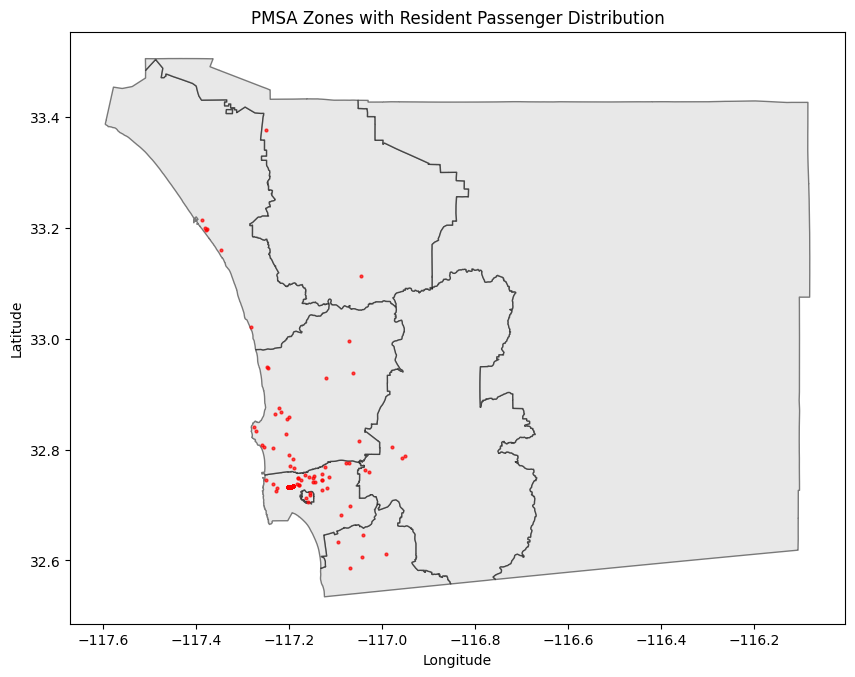

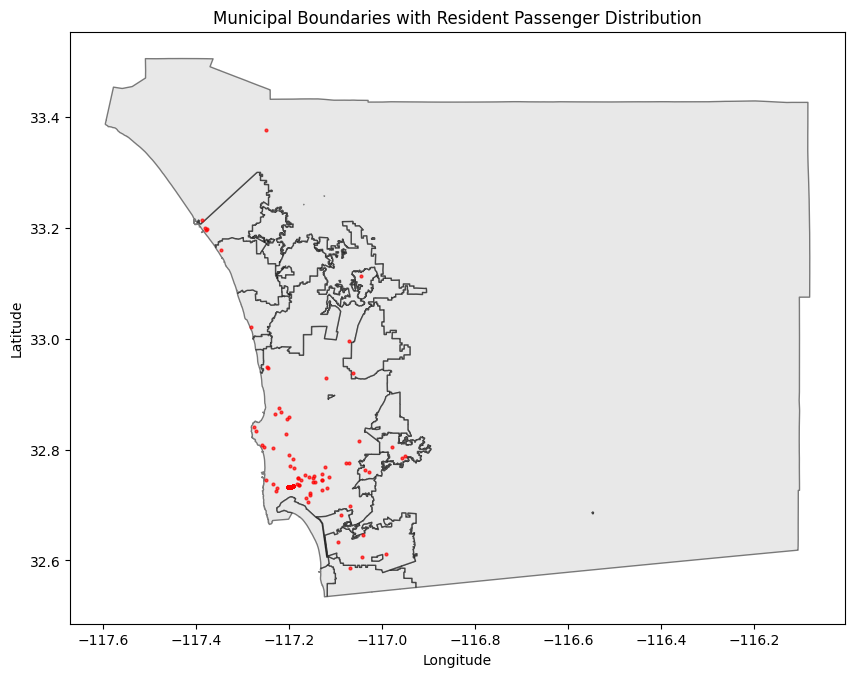

In [8]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load the dataset
df = pd.read_csv('../data/processed/data_model_output.csv')

# Create resident_latitude, resident_longitude, and pmsa fields
filtered_df = df[
    (df["record_type_synthetic"] == 0) & (df['is_completed'] == 1) &
    (df["passenger_segment_label"].isin(["RESIDENT_ARRIVING", "RESIDENT_DEPARTING"]))
].copy()

filtered_df["resident_latitude"] = filtered_df.apply(
    lambda row: row["origin_latitude"] if row["passenger_type_label"] == "RESIDENT_ARRIVING" else row["destination_latitude"], axis=1)
filtered_df["resident_longitude"] = filtered_df.apply(
    lambda row: row["origin_longitude"] if row["passenger_type_label"] == "RESIDENT_ARRIVING" else row["destination_longitude"], axis=1)
filtered_df["pmsa"] = filtered_df.apply(
    lambda row: row["origin_pmsa"] if row["passenger_type_label"] == "RESIDENT_ARRIVING" else row["destination_pmsa"], axis=1)

# Filter out pmsa == 99
filtered_df = filtered_df[filtered_df["pmsa"] != 99]

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(filtered_df['resident_longitude'], filtered_df['resident_latitude'])]
coords_gdf = gpd.GeoDataFrame(filtered_df, geometry=geometry, crs="EPSG:4326")

# Load PMSA and Municipal zones shapefiles
pmsa_zones_gdf = gpd.read_file("../data/external/geometry/pmsa_geoms/pmsa_geoms.shp").to_crs(epsg=4326)
municipal_zones_gdf = gpd.read_file("../data/external/geometry/Municipal_Boundaries/Municipal_Boundaries.shp").to_crs(epsg=4326)

# Plot PMSA Zones with Points
fig, ax = plt.subplots(figsize=(10, 10))
pmsa_zones_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)
coords_gdf.plot(ax=ax, markersize=4, color='red', alpha=0.7)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("PMSA Zones with Resident Passenger Distribution")
plt.show()

# Plot Municipal Boundaries with Points
fig, ax = plt.subplots(figsize=(10, 10))
municipal_zones_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)
coords_gdf.plot(ax=ax, markersize=4, color='red', alpha=0.7)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Municipal Boundaries with Resident Passenger Distribution")
plt.show()
